In [2]:
import Data_Editing_Helpers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pyarrow.parquet as pq
import joblib
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm


In [3]:
# Load data
# test = Data_Editing_Helpers.unCacheOrLoad("test.csv")
# train = Data_Editing_Helpers.unCacheOrLoad("train.csv")
# train_parq = Data_Editing_Helpers.unCacheOrLoad("series_train.parquet")
# test_parq = Data_Editing_Helpers.unCacheOrLoad("series_test.parquet")
train = pd.read_csv('/Users/thiennguyenba/Documents/School/DataScience/Child-mind-institute-club/train.csv')
test = pd.read_csv('/Users/thiennguyenba/Documents/School/DataScience/Child-mind-institute-club/test.csv')

In [4]:
# Dropping columns
toDrop = ['Physical-BMI',
          'Physical-Height',
          'Physical-Weight',
          'Physical-Diastolic_BP',
          'Physical-Systolic_BP',
          'FGC-FGC_GSND',
          'FGC-FGC_GSD',
          'FGC-FGC_PU',
          'BIA-BIA_BMC',
          'BIA-BIA_BMI',
          'BIA-BIA_BMR',
          'BIA-BIA_DEE',
          'BIA-BIA_ECW',
          'BIA-BIA_FFM',
          'BIA-BIA_FFMI',
          'BIA-BIA_FMI',
          'BIA-BIA_Fat',
          'BIA-BIA_ICW',
          'BIA-BIA_LDM',
          'BIA-BIA_LST',
          'BIA-BIA_SMM',
          'BIA-BIA_TBW',
          'PAQ_A-PAQ_A_Total',
          'PAQ_C-PAQ_C_Total']

Data_Editing_Helpers.dropColumns(train, toDrop)
Data_Editing_Helpers.dropColumns(test, toDrop)

In [5]:
# Find out what features is missing in test csv
missingCols = Data_Editing_Helpers.findMissingCols()
Data_Editing_Helpers.dropColumns(train, missingCols)

In [6]:
# Map season to corresponding integer values
#     'Spring': 0,
#     'Summer': 1,
#     'Fall'  : 2,
#     'Winter': 3

Data_Editing_Helpers.map_seasons(file=train)
Data_Editing_Helpers.map_seasons(file=test)

In [7]:
train.head(10)
train.columns

Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season',
       'Physical-Waist_Circumference', 'Physical-HeartRate',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND_Zone',
       'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL',
       'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL',
       'FGC-FGC_TL_Zone', 'BIA-Season', 'BIA-BIA_Activity_Level_num',
       'BIA-BIA_Frame_num', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season',
       'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
       'PreInt_EduHx-computerinternet_hoursday', 'sii'],
      dtype='object')

In [8]:
# Fill na values with median value of corresponding column
train.fillna(train.drop('id', axis=1).median(), inplace=True)
test.fillna(test.drop('id', axis=1).median(), inplace=True)

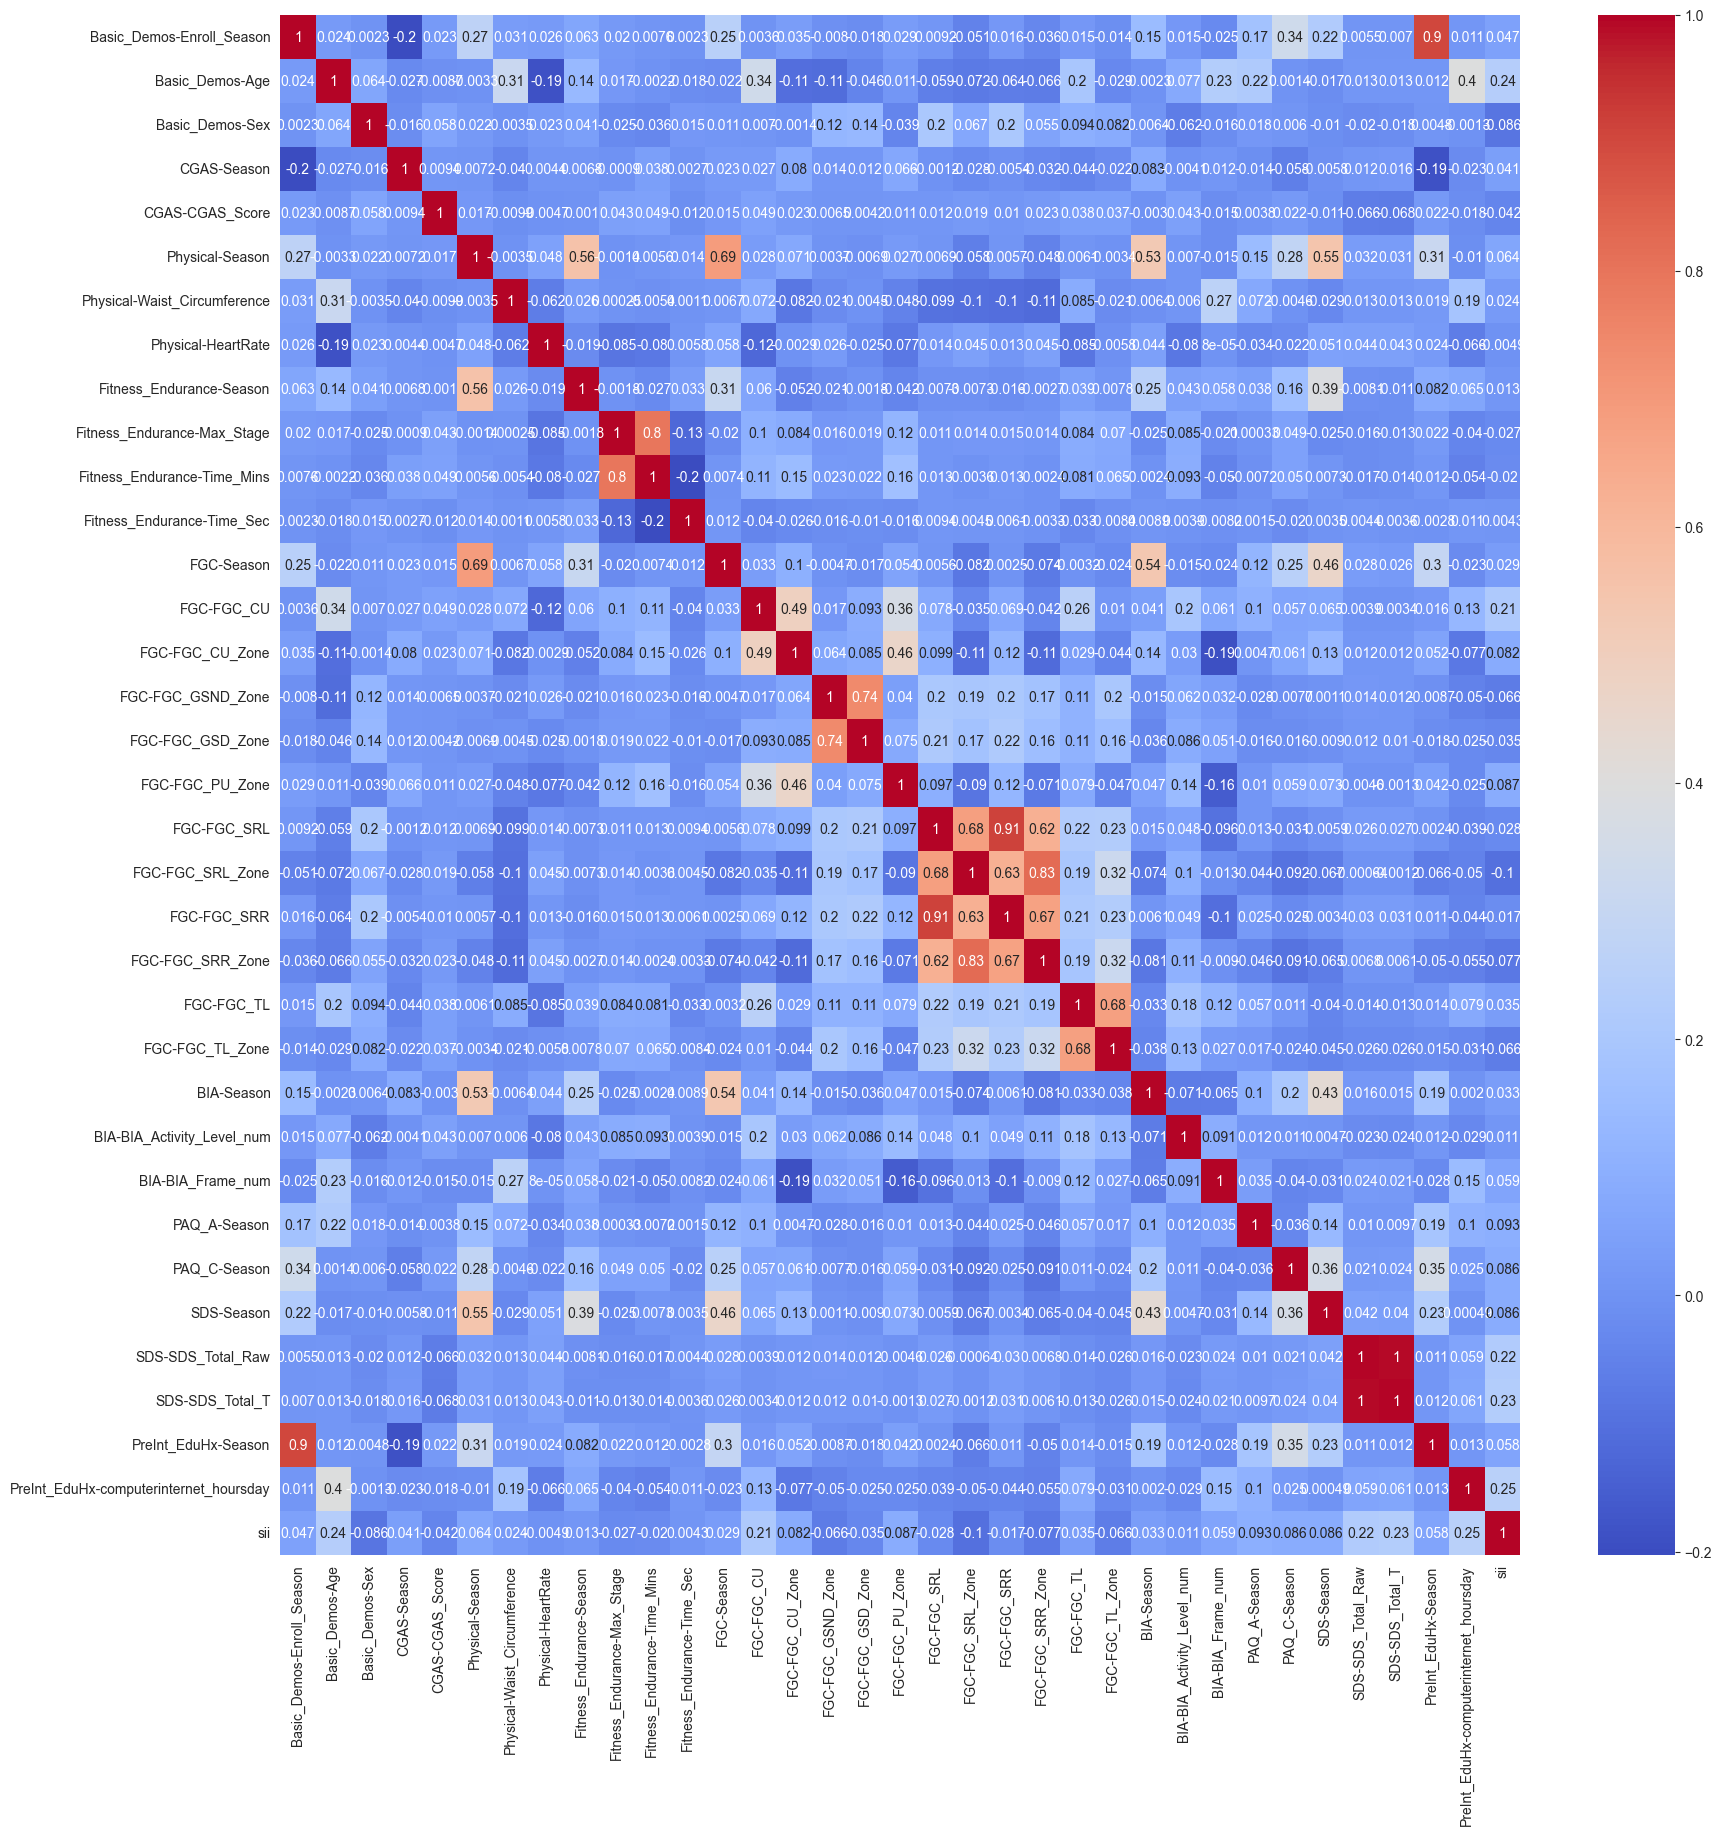

In [9]:
corr_matrix = train.drop('id', axis=1).corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [10]:
# Since season doesn't have strong correlation (less than .1) -> drop season
for col in train.columns:
    if 'Season' in str(col):
        train.drop(col, axis=1, inplace=True)
        
for col in test.columns:
    if 'Season' in str(col):
        test.drop(col, axis=1, inplace=True)

In [11]:
train.columns

Index(['id', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score',
       'Physical-Waist_Circumference', 'Physical-HeartRate',
       'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins',
       'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU_Zone',
       'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone',
       'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-BIA_Activity_Level_num',
       'BIA-BIA_Frame_num', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T',
       'PreInt_EduHx-computerinternet_hoursday', 'sii'],
      dtype='object')

In [12]:
# Handling parquet files
ts_to_drop = ['step',
              'non-wear_flag',
              'battery_voltage']
def process(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop(ts_to_drop, axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    ids.remove('.DS_Store') # idk why macos create this .DS_Store randomly out of nowhere and it will raise an error
    
    with ThreadPoolExecutor() as executor:
        results: list[tuple] = list(tqdm(executor.map(lambda fname: process(fname, dirname), ids), total=len(ids)))


    stats, indexes = zip(*results) # unpack result

    df = pd.DataFrame(stats, columns=[f"Stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes

    return df

train_ts = load_time_series("/Users/thiennguyenba/Documents/School/DataScience/Child-mind-institute-club/series_train.parquet")
test_ts = load_time_series("/Users/thiennguyenba/Documents/School/DataScience/Child-mind-institute-club/series_test.parquet")


100%|██████████| 2/2 [00:00<00:00, 27.85it/s]


In [13]:
train_ts.head()

,Stat_0,Stat_1,Stat_2,Stat_3,Stat_4,Stat_5,Stat_6,Stat_7,Stat_8,Stat_9,...,Stat_71,Stat_72,Stat_73,Stat_74,Stat_75,Stat_76,Stat_77,Stat_78,Stat_79,id
0,269335.0,269335.0,269335.0,269335.0,269335.0,269335.0,269335.0,269335.0,269335.0,269335.0,...,2.525316,1.802745,4.568309,89.673332,2659.666748,8.639500e+13,7.0,1.0,63.0,0d01bbf2
1,412332.0,412332.0,412332.0,412332.0,412332.0,412332.0,412332.0,412332.0,412332.0,412332.0,...,1.518311,1.510279,3.006919,89.322289,2648.000000,8.639500e+13,7.0,3.0,37.0,cefdb7fe
2,384228.0,384228.0,384228.0,384228.0,384228.0,384228.0,384228.0,384228.0,384228.0,384228.0,...,1.381445,1.041023,4.491224,88.801147,1157.250000,8.639500e+13,7.0,1.0,47.0,58391429
3,311959.0,311959.0,311959.0,311959.0,311959.0,311959.0,311959.0,311959.0,311959.0,311959.0,...,3.186745,2.724948,4.054967,89.521629,2648.500000,8.639500e+13,7.0,3.0,67.0,2ca2206f
4,377160.0,377160.0,377160.0,377160.0,377160.0,377160.0,377160.0,377160.0,377160.0,377160.0,...,2.343212,2.094606,5.087605,89.960457,2408.199951,8.639500e+13,7.0,1.0,31.0,19455336


In [14]:
train = pd.merge(train, train_ts, how='left', on='id')
test = pd.merge(test, test_ts, how='left', on='id')

In [15]:
result = train[train['id'] == '0d01bbf2']
print(result)

           id  Basic_Demos-Age  Basic_Demos-Sex  CGAS-CGAS_Score  \
230  0d01bbf2                9                0             55.0   

     Physical-Waist_Circumference  Physical-HeartRate  \
230                          26.0                94.0   

     Fitness_Endurance-Max_Stage  Fitness_Endurance-Time_Mins  \
230                          6.0                          9.0   

     Fitness_Endurance-Time_Sec  FGC-FGC_CU  ...   Stat_70   Stat_71  \
230                        51.0         3.0  ...  1.159667  2.525316   

      Stat_72   Stat_73    Stat_74      Stat_75       Stat_76  Stat_77  \
230  1.802745  4.568309  89.673332  2659.666748  8.639500e+13      7.0   

     Stat_78  Stat_79  
230      1.0     63.0  

[1 rows x 106 columns]


In [16]:
train.head()

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Waist_Circumference,Physical-HeartRate,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,...,Stat_70,Stat_71,Stat_72,Stat_73,Stat_74,Stat_75,Stat_76,Stat_77,Stat_78,Stat_79
0,00008ff9,5,0,51.0,26.0,81.0,5.0,7.0,28.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,9,0,65.0,22.0,70.0,5.0,7.0,28.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,10,1,71.0,26.0,94.0,5.0,7.0,33.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,9,0,71.0,26.0,97.0,6.0,9.0,37.0,18.0,...,1.507865,1.666354,1.546979,4.004276,89.751656,2633.25,8.611000e+13,7.0,3.0,85.0
4,0016bb22,18,1,65.0,26.0,81.0,5.0,7.0,28.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
train.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Waist_Circumference,Physical-HeartRate,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-FGC_CU,FGC-FGC_CU_Zone,...,Stat_70,Stat_71,Stat_72,Stat_73,Stat_74,Stat_75,Stat_76,Stat_77,Stat_78,Stat_79
count,3960.000000,3960.000000,3960.00000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,...,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,9.960000e+02,996.000000,996.000000,996.000000
mean,10.433586,0.372727,65.27803,26.289924,81.447475,4.997980,7.069192,27.921717,10.325000,0.274495,...,1.672994,2.157886,1.875645,3.674156,88.888246,2335.652809,8.628980e+13,6.933735,2.615462,78.834337
std,3.574648,0.483591,17.46905,2.703558,11.830762,0.871945,1.385619,7.652297,9.109182,0.446316,...,0.881167,0.934672,0.911899,1.459785,3.313411,898.044846,8.984971e+11,0.504877,1.158635,86.447984
min,5.000000,0.000000,25.00000,18.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.395664,0.694427,0.167161,0.140138,11.565893,26.500000,6.980500e+13,2.000000,1.000000,-119.000000
25%,8.000000,0.000000,61.00000,26.000000,76.000000,5.000000,7.000000,28.000000,7.000000,0.000000,...,1.120858,1.295791,1.230632,2.790156,88.972979,2512.600098,8.639500e+13,7.000000,2.000000,30.000000
50%,10.000000,0.000000,65.00000,26.000000,81.000000,5.000000,7.000000,28.000000,9.000000,0.000000,...,1.486703,2.112647,1.740934,3.806256,89.377281,2613.625000,8.639500e+13,7.000000,3.000000,51.000000
75%,13.000000,1.000000,68.00000,26.000000,87.000000,5.000000,7.000000,28.000000,10.000000,1.000000,...,1.899864,2.779450,2.234637,4.593709,89.651743,2637.000000,8.639500e+13,7.000000,4.000000,90.000000
max,22.000000,1.000000,999.00000,50.000000,138.000000,28.000000,20.000000,59.000000,115.000000,1.000000,...,8.022779,7.906950,8.125557,11.326200,89.981140,20445.500000,8.639500e+13,7.000000,4.000000,748.000000


In [18]:
print(len(train) - len(train_ts))
print('train: ' + str(len(train)))
print('test_ts: ' + str(len(train_ts)))

2964
train: 3960
test_ts: 996


Not all id from train.csv and test.csv has a corresponding parquet file